## Отток клиентов

<a href='#section1'>1. Подготовка данных</a>

<a href='#section2'>2. Исследование задачи</a>

<a href='#section3'>3. Борьба с дисбалансомх</a>

<a href='#section4'>4. Тестирование модели</a>

<a href='#section5'>5. Вывод</a>

<a id='section1'></a>
### 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

data = data.rename(columns = {'RowNumber': 'row_number',
              'CustomerId': 'customer_id',
              'Surname': 'surname',
              'CreditScore': 'credit_score',
              'Geography': 'geography',
              'Gender': 'gender',
              'Age': 'age',
              'Tenure': 'tenure',
              'Balance': 'balance',
              'NumOfProducts': 'num_of_products',
              'HasCrCard': 'has_cr_card',
              'IsActiveMember': 'is_active_member',
              'EstimatedSalary': 'estimated_salary',
              'Exited': 'exited'})
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
row_number          10000 non-null int64
customer_id         10000 non-null int64
surname             10000 non-null object
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              9091 non-null float64
balance             10000 non-null float64
num_of_products     10000 non-null int64
has_cr_card         10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null float64
exited              10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Файл с данными содержит 10 тысяч строк и 14 столбцов. В столбце с количеством недвижимости есть пропуски.

In [3]:
def tenure(elem):
    if np.isnan(elem['tenure']):
        start = elem['age'] - 2
        end = elem['age'] + 2
        return round(data[data['age'].between(start, end)]['tenure'].mean())
        
    return elem['tenure']


data['tenure'] = data.apply(tenure, axis = 1)
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

Пропуски в столбце tenure не заполняем, т.к. их достаточно много - почти 10%, количество распределено почти равномерно для значений от 1 до 9, поэтому средним или медианой не стала заполнять и по другим столбцам предположить сложно количество недвижимости у клиента.
Убираем столбец tenure и признаки, которые не влияют на исследование - номера строк, идентификатор клиента, фамилию.

<div class="alert" style="background:#F4E0F9">Пропуски в столбце tenure могли появиться потому что люди скрывают количество недвижимости или она находится за границей и банки не могут это отследить. Заполнила их средним в диапазоне для людей этого возраста. Но значения получились везде одинаковые - 5</div>

In [4]:
# Обработка категориальных признаков техникой One-Hot Encoding
data_ohe = pd.get_dummies(data, drop_first = True)

In [5]:
# Отделение целевого признака от остальных
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

# Разделение данных на выборки
features_temp, features_valid, target_temp, target_valid = train_test_split(
    features, target, stratify=target, test_size=0.2, random_state=12345) 
features_train, features_test, target_train, target_test = train_test_split(
    features_temp, target_temp, stratify=target_temp, test_size=0.25, random_state=12345) 

In [6]:
# Столбцы с числовыми данными
numeric = ['credit_score', 'age', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member']

# Масштабирование данных
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [7]:
print('Размеры полученных наборов:')
print('тренировочный - ', features_train.shape[0])
print('валидационный - ', features_valid.shape[0])
print('тестовый - ', features_test.shape[0])
features_train.head()

Размеры полученных наборов:
тренировочный -  6000
валидационный -  2000
тестовый -  2000


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
5536,-0.143332,0.577533,5.0,-1.220573,0.797767,0.652576,0.967527,159463.80,0,1,1
8530,1.632702,-0.564119,2.0,0.435807,-0.916018,0.652576,-1.033563,113907.80,0,0,0
1762,1.116413,-0.468981,1.0,1.245822,-0.916018,0.652576,0.967527,60728.89,0,0,0
9090,1.643028,0.006707,5.0,-1.220573,-0.916018,0.652576,-1.033563,77705.75,0,0,0
8777,-0.484083,-1.420358,1.0,1.421989,0.797767,0.652576,-1.033563,21858.28,0,1,1


В процессе подготовки данных сначала обрабатываем категориальные признаки(страна и пол) техникой One-Hot Encoding, затем разделяем их на выборки: тренировочную, валидационную и тестовую в пропорциях - 60/20/20%. Далее масштабируем числовые данные.

<a id='section2'></a>
### 2. Исследование задачи

In [8]:
result = pd.DataFrame(columns=['Алгоритм', 'Выравниванию классов', 'F1', 'AUC-ROC', 'Описание'])

In [9]:
rfc = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 100, 10),
              'max_depth': range (1,11)}
grid = GridSearchCV(rfc, parametrs)
grid.fit(features_train, target_train)
forest_estimators = grid.best_params_['n_estimators']
forest_depth = grid.best_params_['max_depth']
print('Подобранные гиперпараметры для модели случайного леса')
grid.best_params_

Подобранные гиперпараметры для модели случайного леса


{'max_depth': 9, 'n_estimators': 90}

In [10]:
lr = LogisticRegression()
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_lr = GridSearchCV(lr, param_grid=grid_values)
grid_lr.fit(features_train, target_train)
lr_c = grid_lr.best_params_['C']
lr_penalty = grid_lr.best_params_['penalty']
print('Подобранные гиперпараметры для логистической регрессии')
grid_lr.best_params_

Подобранные гиперпараметры для логистической регрессии


{'C': 1, 'penalty': 'l1'}

In [11]:
model = LogisticRegression(penalty = lr_penalty, C = lr_c, random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
result.loc[len(result)] = ('Логистическая регрессия', 'нет', f1, auc_roc, '') 
print('Логистическая регрессия')
print("F1:", f1)
print("AUC-ROC", auc_roc)

Логистическая регрессия
F1: 0.2985074626865672
AUC-ROC 0.7747855713957408


In [12]:
model = RandomForestClassifier(n_estimators = forest_estimators, max_depth = forest_depth, random_state=12345)
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
result.loc[len(result)] = ('Случайный лес', 'нет', f1, auc_roc, '') 
print('Случайный лес')
print("F1:", f1)
print("AUC-ROC", auc_roc)

Случайный лес
F1: 0.5383360522022839
AUC-ROC 0.8723746859340079


Метрика F1 равна 0, AUC-ROC равна 0.5 как у случайной модели, классы несбалансироны.
Для исследования используем логистическую регрессию.

<div class="alert" style="background:#F4E0F9">Исследовала также случайный лес. После добавление параметров и использования параметра stratify при разделении выборок метрика f1 стала больше нуля, а AUC-ROC увеличилась</div>

<a id='section3'></a>
### 3. Борьба с дисбалансом

In [13]:
model = LogisticRegression(penalty = lr_penalty,
                           C = lr_c,
                           random_state=12345,
                           solver='liblinear',
                           class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
result.loc[len(result)] = ('Логистическая регрессия', 'есть', f1, auc_roc, '') 
print('Логистическая регрессия')
print("F1:", f1)
print("AUC-ROC", auc_roc)

Логистическая регрессия
F1: 0.5076660988074957
AUC-ROC 0.7811787133821033


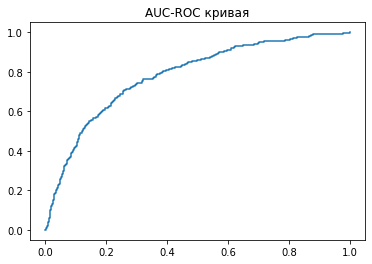

In [14]:
fpr_lr, tpr_lr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.title('AUC-ROC кривая')
plt.plot(fpr_lr, tpr_lr)

In [15]:
model = RandomForestClassifier(n_estimators = forest_estimators,
                               max_depth = forest_depth,
                               random_state=12345,
                               class_weight = 'balanced')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
result.loc[len(result)] = ('Случайный лес', 'есть', f1, auc_roc, '') 
print('Случайный лес')
print("F1:", f1)
print("AUC-ROC", auc_roc)

Случайный лес
F1: 0.6409966024915063
AUC-ROC 0.8643173219444407


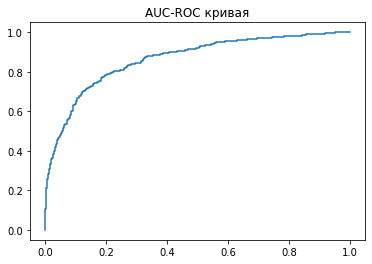

In [16]:
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.title('AUC-ROC кривая')
plt.plot(fpr_forest, tpr_forest)

In [17]:
# уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]) 
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]) 
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [18]:
model = RandomForestClassifier(n_estimators = forest_estimators,
                               max_depth = forest_depth,
                               random_state=12345,
                               class_weight = 'balanced')
model.fit(features_downsampled, target_downsampled) 
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
result.loc[len(result)] = ('Случайный лес', 'есть', f1, auc_roc, 'уменьшена выборка') 
print('Случайный лес на уменьшенной выборке')
print("F1:", f1)
print("AUC-ROC", auc_roc)

Случайный лес на уменьшенной выборке
F1: 0.5357933579335793
AUC-ROC 0.8651548312565264


In [19]:
model = LogisticRegression(penalty = lr_penalty,
                           C = lr_c,
                           random_state=12345,
                           solver='liblinear',
                           class_weight = 'balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
result.loc[len(result)] = ('Логистическая регрессия', 'есть', f1, auc_roc, 'уменьшена выборка') 
print('Логистическая регрессия на уменьшенной выборке')
print("F1:", f1)
print("AUC-ROC", auc_roc)

Логистическая регрессия на уменьшенной выборке
F1: 0.5033670033670034
AUC-ROC 0.7790625756727451


Для борьбы с дисбалансом классов используем гиперпарамерт class_weight = 'balanced'.

Показатели улучшились, но нужное значение F1-меры ещё не достигнуто.

Применим модель случайного леса.

Модель случайного леса показала лучший результат на валидационной выборке. В цикле подобрали оптимальные гиперпараметы.
<a id='section4'></a>
### 4. Тестирование модели

In [20]:
new_features = pd.concat([features_train, features_valid], ignore_index=True)
new_target = pd.concat([target_train, target_valid], ignore_index=True)

model = RandomForestClassifier(n_estimators = forest_estimators,
                               max_depth = forest_depth,
                               random_state=12345,
                               class_weight = 'balanced')
model.fit(new_features, new_target) 

predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
f1 = f1_score(target_test, predicted_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
result.loc[len(result)] = ('Случайный лес', 'есть', f1, auc_roc, 'тестовая выборка') 

print("F1:", f1)
print("AUC-ROC", auc_roc)

F1: 0.6352413019079686
AUC-ROC 0.8747730781629086


In [21]:
result

,Алгоритм,Выравниванию классов,F1,AUC-ROC,Описание
0,Логистическая регрессия,нет,0.298507,0.774786,
1,Случайный лес,нет,0.538336,0.872375,
2,Логистическая регрессия,есть,0.507666,0.781179,
3,Случайный лес,есть,0.640997,0.864317,
4,Случайный лес,есть,0.535793,0.865155,уменьшена выборка
5,Логистическая регрессия,есть,0.503367,0.779063,уменьшена выборка
6,Случайный лес,есть,0.635241,0.874773,тестовая выборка


<a id='section5'></a>
### 5. Вывод
Тестирование полученной модели показало, что мера F1 достигла нужного результата.

Была составлена таблица с результатами. Случайный лес показал более высокие значения метрик по сравнению с логистической регрессией. Для тестовой выборки F1 достигла 0.63, AUC-ROC - 0.87. 
Были подобраны гиперпараметры для моделей.